# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv("Churn.csv")
df.info() # видим пропущенные значения в Tenure около 10% данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
df.head(5) # первый взгляд говорит о том что строчные значения соотвествую объектам, а числовые int и float

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Exited задано как 1 или 0, значит решаем задачу классификации

Рассмотрим данные с пропусками

In [4]:
df1 = df[df.isna().any(axis=1)]
df1.head(5) #видим что это реальные клиенты у которых почему то не заполнен столбец Tenure

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


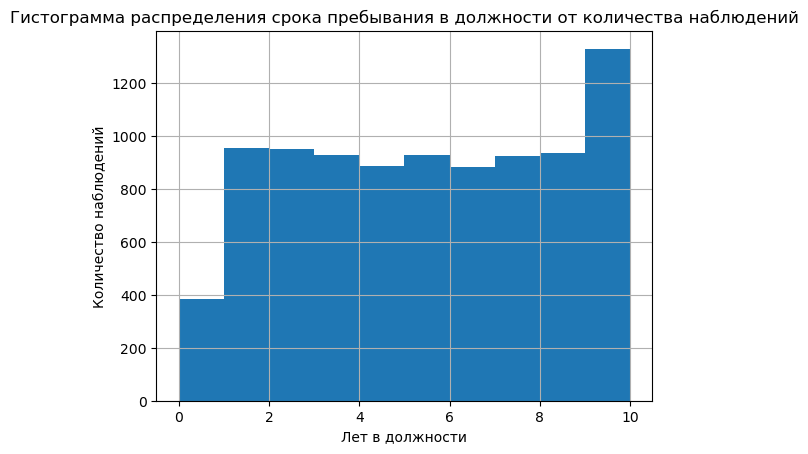

In [5]:
df['Tenure'].hist()                                                                          # распределение достаточно равномерно, можем заполнить пропущенные данные как \
plt.title('Гистограмма распределения срока пребывания в должности от количества наблюдений') #  медианой, средним , так и рандомным значением
plt.xlabel('Лет в должности')
plt.ylabel('Количество наблюдений')
plt.show()    

In [6]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [7]:
df.isna().sum() # пропусков нет

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Подготовка выполнена, приступаем к выполнению задачи

## Исследование задачи

Мы видим что в столбце Balance и EstimatedSalary фигурируют 6ти значные цифры, в то время как например в Tenure до 10. Это означает что мы имеем дело с дизбалансом данных по умолчанию.

Построим модель машинного обучения для целевого параметра Exited. Для бучения модели часть данных нам понадобится, а часть нет. Мы удалим столбцы RowNumber, CustomerId, Surname так как признаки указанные в этих столбцах, например Имя, не могут влиять на лояльность к банку. Сначала построим модель без учета дизбалланса в данных

In [8]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1) # удалим ненужные столбцы

In [9]:
df_ohe = pd.get_dummies(df, drop_first=True) # используем технику прямого кодирования с учетом дамии-ловушки

target_ohe = df_ohe['Exited'] # целевое значение
features_ohe = df_ohe.drop(['Exited'], axis=1) # данные для предсказания целевого значения

features_train, features_valid, target_train, target_valid = train_test_split(
    features_ohe,target_ohe, test_size=0.40, random_state=12345) # отделим 40% данных для валидационной выборки
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345) # делаем пропорцию 3-1-1, обучающая, валидационная и тестовая выборки

numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']

scaler = StandardScaler() # стандартизируем тестовую и валидную выборку, чтобы "уравнять" значения и маленькие и очень большие. 
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 

In [10]:
model = LogisticRegression(solver='liblinear',random_state=12345) # объявим модель как логистическую регрессию
model.fit(features_train, target_train) # обучим модель

predicted_valid = model.predict(features_valid) #предскажем значения Exited на основе обученной модели для данных из валидационной выборки

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1:", f1_score(target_valid,predicted_valid))
print("AUC-ROC:", roc_auc_score(target_valid,probabilities_one_valid))

F1: 0.33108108108108103
AUC-ROC: 0.7588026784580114


F1-мера показывает результат 0.33 для несбалансированных данных используя модель обучения логистической регрессии

In [11]:
model = DecisionTreeClassifier(random_state=12345) # модель обучения дерева решений
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1:", f1_score(target_valid,predicted_valid))
print("AUC-ROC:", roc_auc_score(target_valid,probabilities_one_valid))

F1: 0.5030229746070133
AUC-ROC: 0.6852766469673781


F1-мера показывает результат 0.50 для несбалансированных данных используя модель обучения дерева решений

In [12]:
for depth in range(1,20,1): # модель обучения случайный лес с циклом для перебора гиперпораметра max_depth
    model = RandomForestClassifier(max_depth=depth,n_estimators=50,random_state=12345).fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,predicted_valid))

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.1853448275862069
max_depth: 3 F1: 0.26993865030674846
max_depth: 4 F1: 0.40293040293040294
max_depth: 5 F1: 0.46735395189003437
max_depth: 6 F1: 0.5348837209302326
max_depth: 7 F1: 0.560126582278481
max_depth: 8 F1: 0.5705229793977813
max_depth: 9 F1: 0.5709779179810726
max_depth: 10 F1: 0.5510835913312693
max_depth: 11 F1: 0.5679012345679013
max_depth: 12 F1: 0.5758039816232772
max_depth: 13 F1: 0.5709969788519637
max_depth: 14 F1: 0.5705705705705705
max_depth: 15 F1: 0.5731523378582202
max_depth: 16 F1: 0.5727136431784108
max_depth: 17 F1: 0.5727136431784108
max_depth: 18 F1: 0.5683890577507599
max_depth: 19 F1: 0.5843373493975904


Лучшее значение max_depth=19

In [13]:
for est in range(1,50,1): # модель обучения случайный лес с циклом для перебора гиперпораметра max_depth
    model = RandomForestClassifier(max_depth=19,n_estimators=est,random_state=12345).fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    print('estimators:',est,'F1:',f1_score(target_valid,predicted_valid))

estimators: 1 F1: 0.4819004524886878
estimators: 2 F1: 0.4340836012861737
estimators: 3 F1: 0.5528662420382164
estimators: 4 F1: 0.5007680491551458
estimators: 5 F1: 0.554945054945055
estimators: 6 F1: 0.5345345345345345
estimators: 7 F1: 0.56353591160221
estimators: 8 F1: 0.5413533834586467
estimators: 9 F1: 0.5576102418207682
estimators: 10 F1: 0.5489614243323442
estimators: 11 F1: 0.5657142857142857
estimators: 12 F1: 0.5654761904761905
estimators: 13 F1: 0.5685425685425686
estimators: 14 F1: 0.5519287833827893
estimators: 15 F1: 0.566860465116279
estimators: 16 F1: 0.5595238095238096
estimators: 17 F1: 0.5618631732168851
estimators: 18 F1: 0.5650224215246636
estimators: 19 F1: 0.5793304221251819
estimators: 20 F1: 0.5765230312035662
estimators: 21 F1: 0.5801749271137026
estimators: 22 F1: 0.571001494768311
estimators: 23 F1: 0.5814977973568282
estimators: 24 F1: 0.5722801788375559
estimators: 25 F1: 0.57856093979442
estimators: 26 F1: 0.5803571428571428
estimators: 27 F1: 0.5814977

F1-мера показывает результат 0.59 для несбалансированных данных используя модель обучения случайныйного леса

Промежуточный вывод. Мы решаем задачу классификации по целевому признаку Exited. Сначала мы провели работу с учетом дизбаланса ланных. Мы построили 3 модели обучения для несбалансированных данных для логистической регрессии, дерева решения и случайного леса. И получили F1-меру для данных моделей. Самый лучший результат оказался у случайного леса 0.59. Продолжаем исследование и улучшение моделей.

## Борьба с дисбалансом

Мы видим что не все данные имеют пропорцию 1:1 , это означает что наша модель неизбежно какие то данные недооценивает, а какие то переоценивает. Для этого обучим нашим модели приведя их к балансу. Попробуем указать класс "сбалансированный" в параметре class_weight в логистической модели обучения

In [14]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1:", f1_score(target_valid,predicted_valid))
print("AUC-ROC:", roc_auc_score(target_valid,probabilities_one_valid))

F1: 0.4888507718696398
AUC-ROC: 0.7636266853779661


Мы видим что наша модель улучшиласть F1: 0.49


Попробуем использовать метод увеличения выборки для исследования

In [15]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0] # Разделим обучающую выборку на отрицательные и положительные объекты
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3) # c учётом полученных данных создадим новую обучающую выборку
model = LogisticRegression(random_state=12345,solver='liblinear',class_weight='balanced')
model.fit(features_upsampled,target_upsampled)

predicted_valid = model.predict(features_valid) 

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1:", f1_score(target_valid,predicted_valid))
print("AUC-ROC:", roc_auc_score(target_valid,probabilities_one_valid))

F1: 0.4888507718696398
AUC-ROC: 0.7635949285925997


Методом подбора количества повторений пришли к выводу что лучший результат модель логистической регрессии с учетом 3 повторений для увеличения выборки показала на значении F1-меры 0.49

In [16]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0] 
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.30)

model = LogisticRegression(random_state=12345,solver='liblinear',class_weight='balanced')
model.fit(features_downsampled,target_downsampled)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1:", f1_score(target_valid,predicted_valid))
print("AUC-ROC:", roc_auc_score(target_valid,probabilities_one_valid))

F1: 0.4939759036144578
AUC-ROC: 0.7641363061717044


При уменьшении выборки с коэффециентом 0.30 мы получили лучший для этой модели результат F1: 0.49

Теперь попробуем посмотреть на результаты случайного леса

In [17]:
for depth in range(1,20,1):
    model = RandomForestClassifier(max_depth=depth,n_estimators=50,random_state=12345,class_weight='balanced').fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,predicted_valid))

max_depth: 1 F1: 0.5430954587581093
max_depth: 2 F1: 0.5616045845272206
max_depth: 3 F1: 0.5775301764159704
max_depth: 4 F1: 0.5953757225433527
max_depth: 5 F1: 0.6114398422090729
max_depth: 6 F1: 0.6138211382113822
max_depth: 7 F1: 0.6182965299684542
max_depth: 8 F1: 0.62582056892779
max_depth: 9 F1: 0.6242905788876277
max_depth: 10 F1: 0.6124401913875598
max_depth: 11 F1: 0.6121437422552664
max_depth: 12 F1: 0.5949535192563081
max_depth: 13 F1: 0.598079561042524
max_depth: 14 F1: 0.5977337110481586
max_depth: 15 F1: 0.5947521865889214
max_depth: 16 F1: 0.5905044510385756
max_depth: 17 F1: 0.58493353028065
max_depth: 18 F1: 0.5740458015267176
max_depth: 19 F1: 0.5687789799072643


In [18]:
for est in range(1,50,1):
    model = RandomForestClassifier(max_depth=8,n_estimators=est,random_state=12345,class_weight='balanced').fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    print('estimators:',est,'F1:',f1_score(target_valid,predicted_valid))

estimators: 1 F1: 0.5486381322957198
estimators: 2 F1: 0.5546558704453441
estimators: 3 F1: 0.5825641025641026
estimators: 4 F1: 0.5777310924369747
estimators: 5 F1: 0.5888538380651946
estimators: 6 F1: 0.6016949152542372
estimators: 7 F1: 0.6081370449678801
estimators: 8 F1: 0.6118918918918919
estimators: 9 F1: 0.6256860592755213
estimators: 10 F1: 0.6225596529284164
estimators: 11 F1: 0.6175514626218851
estimators: 12 F1: 0.6163934426229508
estimators: 13 F1: 0.6145494028230185
estimators: 14 F1: 0.6138828633405641
estimators: 15 F1: 0.6266375545851528
estimators: 16 F1: 0.6190998902305158
estimators: 17 F1: 0.6131868131868131
estimators: 18 F1: 0.6147091108671789
estimators: 19 F1: 0.6142076502732241
estimators: 20 F1: 0.616557734204793
estimators: 21 F1: 0.611353711790393
estimators: 22 F1: 0.614879649890591
estimators: 23 F1: 0.6179039301310043
estimators: 24 F1: 0.6209150326797385
estimators: 25 F1: 0.6266375545851528
estimators: 26 F1: 0.6217391304347827
estimators: 27 F1: 0.619

Выяснили что лучший max_depth=8 а estimators=47, при этих параметрах сбалансированная модель достигает F1 = 0.63 на валидационной выборке

## Тестирование модели

In [19]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_ohe,target_ohe, test_size=0.40, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345)

model = RandomForestClassifier(random_state=12345,n_estimators=47,max_depth=8,class_weight='balanced')

model.fit(features_train,target_train) 

predicted_test = model.predict(features_test)

print("F1:", f1_score(target_test,predicted_test))

F1: 0.6023835319609968


Самая лучшая модель случайного леса показала результат F1 меры равный 0.60 по сравнению с 0.63 на валидационной выборке

In [20]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

roc_auc_score(target_test,probabilities_one_test)

0.8551173713142979

Мы получили результат 0.86 что выше случайной модели равной 0.5

## Итоговый вывод

Из банка стали уходить клиенты.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.
Мы построили модель с предельно большим значением F1-меры и проверили ее на тестовой выборке.

1) Мы провели первичный анализ данных и сделали вывод что будем решать задачу классификации. Мы обнаружили недоставющие данные и заполнили их медианным щначением. 

2) Исследовали балансы классов и решили что построим несколько моделей сначала несбалансированные, затем сбалансированные.
Построили модели без учета баланса и получили результаты: F1-мера показывает результат 0.33 для несбалансированных данных используя модель обучения логистической регрессии, 0.50 используя модель обучения дерева решений, самый лучший результат оказался у случайного леса 0.59

3) Далее мы использовали несколько методов балансировки чтобы попробовать разные модели и найти лучшую. Модель с логистической регрессией удалось улучшить F1: 0.49 в этот раз. Лучший результат модели логистической регрессии для увеличения выборки показала на значении F1-меры 0.45. При уменьшении выборки мы получили лучший для этой модели результат F1: 0.46, случайны лес показал результат в 0.63

4) Получив результаты разных моделей приступили к тестированию их на тестовых данных. Мы протестировали модель случайного леса с валидационным резульатом 0.63 на тестовой выборке и получили результат в 0.60, что оказалось меньше результата на валидационной выборке. Исследование метрики AUC-ROC показало что модель показывает резульат в 0.86, что выше модели случайной выборки с результатом 0.5